In [1]:
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torch
import numpy as np
import torchvision.transforms as transforms
import argparse
import time
import random
import numpy.ma as ma
import copy
import scipy.misc
import scipy.io as scio
from lib.proj_utils import *
from lib.transformations import translation_matrix, quaternion_matrix, quaternion_from_matrix
import quaternion as qua
from so3_data import *

%load_ext autoreload
%autoreload 2

/home/qiaog/courses/16720B-project/SO3/lib/transformations.py:1912: UserWarning: failed to import module _transformations
  warnings.warn('failed to import module %s' % name)


/home/qiaog/courses/16720B-project/SO3/data/car_ycb/models


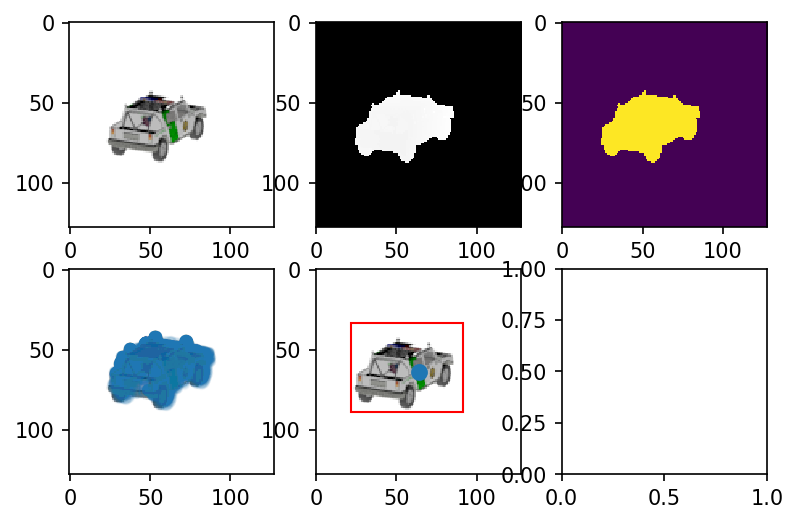

In [2]:
cat = "car"
# data_dir = "/hdd/zen/dev/6dof/6dof_data/"
data_dir = "/home/qiaog/courses/16720B-project/SO3/data"

model_index = "0001"
index = 0
print(os.path.join(data_dir, cat +"_ycb", "models"))
cld = read_pointxyz( os.path.join(data_dir, cat +"_ycb", "models"))
value, boxes, img_color, depth_img, semantic = diplay_gen_ycb(cat, data_dir, cld, model_index, index)

initialize train_dataset
400
meta['poses'][:, :, idx]:
[[ 9.7957100e-01  0.0000000e+00  2.0109800e-01  2.9009000e-02]
 [ 1.4263400e-01 -7.0492800e-01 -6.9478900e-01  7.1282000e-02]
 [-1.4176000e-01 -7.0927900e-01  6.9052800e-01  2.9826145e+01]]
R
[[-9.99999850e-01 -6.90688104e-07  1.45480022e-08]
 [ 0.00000000e+00  1.00000009e+00 -7.89119917e-07]
 [ 0.00000000e+00  0.00000000e+00  1.00000054e+00]]
target_r mat:
[[ 9.79571147e-01 -6.76578075e-07  2.01097906e-01]
 [ 1.42634021e-01 -7.04928033e-01 -6.94789179e-01]
 [-1.41760021e-01 -7.09278836e-01  6.90527066e-01]]
target_r quat:
[-0.40775432  0.10677491  0.31660563 -0.84976256]
rt_mat mat:
[[-0.64467105 -0.62537765 -0.43966126  0.        ]
 [ 0.7605998  -0.46699457 -0.45100335  0.        ]
 [ 0.076728   -0.62515507  0.77671999  0.        ]
 [ 0.          0.          0.          1.        ]]
[[-6.44671051e-01 -6.25377655e-01 -4.39661261e-01  2.90089995e-02]
 [ 7.60599796e-01 -4.66994566e-01 -4.51003355e-01  7.12819993e-02]
 [ 7.67280008e-

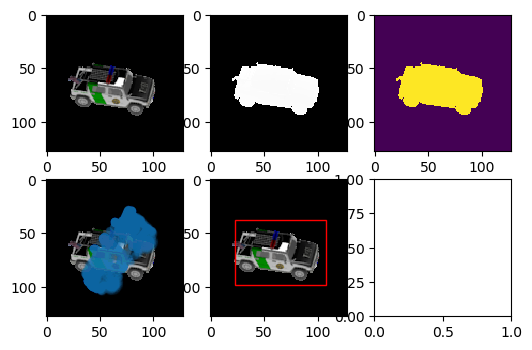

------------------------------------------------------------------------------------------


In [39]:
import matplotlib.pyplot as plt
seed = 2022
# seed = 2018
random.seed(seed)
np.random.seed(seed)

# dataset_root = "/hdd/zen/dev/6dof/6dof_data/car_ycb"
dataset_root = "/home/qiaog/courses/16720B-project/SO3/data/car_ycb"
transform=transforms.Compose([transforms.ToTensor()])
print("initialize train_dataset")
train_dataset = PoseDataset('train', dataset_root, transforms=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)

# test_dataset = PoseDataset('test', dataset_root, transforms=transform)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=1)


## Data inspection 
for j, data in enumerate(train_loader, 0):
    img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
    for i in range(img.shape[0]):
#     for i in range(1):
        display_load_img(img[i], depth[i], boxes[i][0], label[i], cam[i], pose_t[i], pose_r[i], train_dataset.models[idx[i]])
        print("------------------------------------------------------------------------------------------")
    break

# Data Training loop 
# for i, data in enumerate(train_loader, 0):
#     img, depth, boxes, label, pose_r, pose_t,  cam,idx= data
#     print(pose_r.shape)
#     quat = quaternion_from_matrix(pose_r)
#     break
    


In [104]:
import quaternion as qua
qua.from_rotation_matrix(pose_r)

quaternion(0.642956057093082, 0.0919537558328988, 0.640750691123455, 0.4093782691599)